<a href="https://colab.research.google.com/github/AnkurMali/IST597_SP21/blob/main/IST597_SP21_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597 :Recurrent Neural Networks (RNNs) for sequence classification
Thanks to @googleAI, @Keras, @madlalina @nvidia_research 
----

We will be  building a RNN for sentiment analysis on IMDB movie reviews ( [stanford_imdb](https://https://ai.stanford.edu/~amaas/data/sentiment/)). 


In [15]:
import tensorflow as tf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(6447)

Data-utils.py import was not working, so I copy pasted the file into the next cell!

In [16]:
'''
This script contains several functions used for data processing.
'''

#############################################################################
# Import here useful libraries
#############################################################################
from nltk.tokenize import word_tokenize
import tensorflow as tf
import pandas as pd
import pickle
import random
import glob
import nltk
import re

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')


def imdb2tfrecords(path_data='datasets/aclImdb/', min_word_frequency=5,
                   max_words_review=700):
    '''
    This script processes the data and saves it in the default TensorFlow 
    file format: tfrecords.
    
    Args:
        path_data: the path where the imdb data is stored.
        min_word_frequency: the minimum frequency of a word, to keep it
                            in the vocabulary.
        max_words_review: the maximum number of words allowed in a review.
    '''
    # Get the filenames of the positive/negative reviews we will use
    # for training the RNN
    train_pos_files = glob.glob(path_data + 'train/pos/*')
    train_neg_files = glob.glob(path_data + 'train/neg/*')

    # Concatenate both positive and negative reviews filenames
    train_files = train_pos_files + train_neg_files
    
    # List with all the reviews in the train dataset
    reviews = [open(train_files[i],'r').read() for i in range(len(train_files))]
    
    # Remove HTML tags
    reviews = [re.sub(r'<[^>]+>', ' ', review) for review in reviews]
        
    # Tokenize each review in part
    reviews = [word_tokenize(review) for review in reviews]
    
    # Compute the length of each review
    len_reviews = [len(review) for review in reviews]
    pickle.dump(len_reviews, open(path_data + 'length_reviews.pkl', 'wb'))

    # Flatten nested list
    reviews = [word for review in reviews for word in review]
    
    # Compute the frequency of each word
    word_frequency = pd.value_counts(reviews)
    
    # Keep only words with frequency higher than minimum
    vocabulary = word_frequency[word_frequency>=min_word_frequency].index.tolist()
    
    # Add Unknown, Start and End token. 
    extra_tokens = ['Unknown_token', 'End_token']
    vocabulary += extra_tokens
    
    # Create a word2idx dictionary
    word2idx = {vocabulary[i]: i for i in range(len(vocabulary))}
    
    # Write word vocabulary to disk
    pickle.dump(word2idx, open(path_data + 'word2idx.pkl', 'wb'))
        
    def text2tfrecords(filenames, writer, vocabulary, word2idx,
                       max_words_review):
        '''
        Function to parse each review in part and write to disk
        as a tfrecord.
        
        Args:
            filenames: the paths of the review files.
            writer: the writer object for tfrecords.
            vocabulary: list with all the words included in the vocabulary.
            word2idx: dictionary of words and their corresponding indexes.
        '''
        # Shuffle filenames
        random.shuffle(filenames)
        for filename in filenames:
            review = open(filename, 'r').read()
            review = re.sub(r'<[^>]+>', ' ', review)
            review = word_tokenize(review)
            # Reduce review to max words
            review = review[-max_words_review:]
            # Replace words with their equivalent index from word2idx
            review = [word2idx[word] if word in vocabulary else 
                      word2idx['Unknown_token'] for word in review]
            indexed_review = review + [word2idx['End_token']]
            sequence_length = len(indexed_review)
            target = 1 if filename.split('/')[-2]=='pos' else 0
            # Create a Sequence Example to store our data in
            ex = tf.train.SequenceExample()
            # Add non-sequential features to our example
            ex.context.feature['sequence_length'].int64_list.value.append(sequence_length)
            ex.context.feature['target'].int64_list.value.append(target)
            # Add sequential feature
            token_indexes = ex.feature_lists.feature_list['token_indexes']
            for token_index in indexed_review:
                token_indexes.feature.add().int64_list.value.append(token_index)
            writer.write(ex.SerializeToString())
    
    ##########################################################################     
    # Write train data to tfrecords.This might take a while (~10 minutes)
    ##########################################################################
    train_writer = tf.python_io.TFRecordWriter(path_data + 'train.tfrecords')
    text2tfrecords(train_files, train_writer, vocabulary, word2idx, 
                   max_words_review)

    ##########################################################################
    # Get the filenames of the reviews we will use for testing the RNN 
    ##########################################################################
    test_pos_files = glob.glob(path_data + 'test/pos/*')
    test_neg_files = glob.glob(path_data + 'test/neg/*')
    test_files = test_pos_files + test_neg_files

    ##########################################################################
    # Write test data to tfrecords (~10 minutes)
    ##########################################################################
    test_writer = tf.python_io.TFRecordWriter('datasets/aclImdb/test.tfrecords')
    text2tfrecords(test_files, test_writer, vocabulary, word2idx,
                   max_words_review)


def parse_imdb_sequence(record):
    '''
    Script to parse imdb tfrecords.
    
    Returns:
        token_indexes: sequence of token indexes present in the review.
        target: the target of the movie review.
        sequence_length: the length of the sequence.
    '''
    context_features = {
        'sequence_length': tf.io.FixedLenFeature([], dtype=tf.int64),
        'target': tf.io.FixedLenFeature([], dtype=tf.int64),
        }
    sequence_features = {
        'token_indexes': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        }
    context_parsed, sequence_parsed = tf.io.parse_single_sequence_example(record, 
        context_features=context_features, sequence_features=sequence_features)
        
    return (sequence_parsed['token_indexes'], context_parsed['target'],
            context_parsed['sequence_length'])

     
        


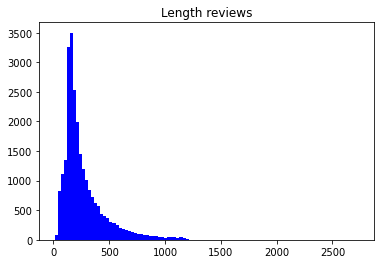

In [17]:
length_reviews = pickle.load(open('/content/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

**Validation Split was missing in starter code!**

In [19]:
train_dataset = tf.data.TFRecordDataset('/content/train.tfrecords')
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))
test_dataset = tf.data.TFRecordDataset('/content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [20]:
total_dataset = train_dataset.concatenate(test_dataset)

In [21]:
train_dataset = total_dataset.take(68) 
test_eval_dataset = total_dataset.skip(68) # val dataset

In [22]:
eval_dataset = test_eval_dataset.take(20) #val dataset
test_dataset = test_eval_dataset.skip(20)

In [23]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/word2idx.pkl', 'rb'))

## RNN model for sequence classification, compatible with Eager API 
----
In the cell below, you can find the class that I have created for the RNN model. The API is very similar with one I created in the previous tutorial, except that now we track the accuracy of the model instead of the loss.

The idea of the network is very simple. We simply take each word in the review, select its corresponding word embedding (initialized randomly in the beginning), and pass it through the RNN cell. We then take the output of the RNN cell at the end of the sequence and pass it through a dense layer (with ReLU activation) to obtain the final predictions. 

Like usually, the network inherits from tf.keras.Model in order to keep track of all variables and save/restore them easily.

![img](tutorials_graphics/rnn_imdb.png)

In [24]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train model with gradient descent and early stopping
----

### Model training with simple LSTM cells
----

In [25]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [26]:
!pip install -q tf-models-official==2.7.0

In [27]:
from official.nlp import optimization  # to create AdamW optimizer

In [28]:
epochs = 20
steps_per_epoch = 68
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-4


optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [29]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [30]:
# Train model
lstm_model.fit(train_dataset, eval_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.6173981
Eval accuracy at epoch 1:  0.6100586
Train accuracy at epoch 2:  0.72872037
Eval accuracy at epoch 2:  0.71533203
Train accuracy at epoch 3:  0.8035303
Eval accuracy at epoch 3:  0.7925781
Train accuracy at epoch 4:  0.8490843
Eval accuracy at epoch 4:  0.83554685
Train accuracy at epoch 5:  0.88493437
Eval accuracy at epoch 5:  0.86445314
Train accuracy at epoch 6:  0.9042847
Eval accuracy at epoch 6:  0.8780273
Train accuracy at epoch 7:  0.92115873
Eval accuracy at epoch 7:  0.890625
Train accuracy at epoch 8:  0.9274937
Eval accuracy at epoch 8:  0.9013672
Train accuracy at epoch 9:  0.9405091
Eval accuracy at epoch 9:  0.91308594
Train accuracy at epoch 10:  0.9478519
Eval accuracy at epoch 10:  0.9129883
Train accuracy at epoch 11:  0.953179
Eval accuracy at epoch 11:  0.9208008
Train accuracy at epoch 12:  0.9556266
Eval accuracy at epoch 12:  0.92089844
Train accuracy at epoch 13:  0.96170235
Eval accuracy at epoch 13:  0.9242188
Train accu

In [31]:
#lstm_model.save_model()
checkpoint = tf.train.Checkpoint(lstm_model)
save_path = checkpoint.save(checkpoint_directory)

In [32]:
history = {}

def evaluate(test_data):
        test_acc=tf.keras.metrics.Accuracy('test_acc')
        history['test_acc'] = []
        # Check accuracy test dataset
        for step, (X, y, seq_length) in enumerate(test_data):
          logits = lstm_model.predict(X, seq_length, False)
          preds = tf.argmax(logits, axis=1)
          test_acc(preds, y)
        history['test_acc'].append(test_acc.result().numpy())
        
        print('Test accuracy is {}' .format(history['test_acc'][-1]))
      
        # Reset metrics
        test_acc.reset_states()

In [33]:
evaluate(test_dataset)

Test accuracy is 0.9205087423324585


### Model training with RNN cells 
---

In [34]:
epochs = 20
steps_per_epoch = 10
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-4


optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [35]:
# Define optimizer.
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.


In [36]:
# Train model
ugrnn_model.fit(train_dataset, eval_dataset, optimizer, num_epochs=20, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.6303271
Eval accuracy at epoch 1:  0.5931641
Train accuracy at epoch 2:  0.7066056
Eval accuracy at epoch 2:  0.6737305
Train accuracy at epoch 3:  0.76287144
Eval accuracy at epoch 3:  0.75205076
Train accuracy at epoch 4:  0.7625259
Eval accuracy at epoch 4:  0.74658203
Train accuracy at epoch 5:  0.762929
Eval accuracy at epoch 5:  0.74667966
Train accuracy at epoch 6:  0.7627851
Eval accuracy at epoch 6:  0.74794924
Train accuracy at epoch 7:  0.76223797
Eval accuracy at epoch 7:  0.7475586
Train accuracy at epoch 8:  0.7614605
Eval accuracy at epoch 8:  0.75283206
Train accuracy at epoch 9:  0.76226676
Eval accuracy at epoch 9:  0.75498044
Train accuracy at epoch 10:  0.7627275
Eval accuracy at epoch 10:  0.7493164
Train accuracy at epoch 11:  0.761806
Eval accuracy at epoch 11:  0.74785155
Train accuracy at epoch 12:  0.76347613
Eval accuracy at epoch 12:  0.74794924
Train accuracy at epoch 13:  0.763073
Eval accuracy at epoch 13:  0.74794924
Train a

In [37]:
history = {}

def evaluate(test_data):
        test_acc=tf.keras.metrics.Accuracy('test_acc')
        history['test_acc'] = []
        # Check accuracy test dataset
        for step, (X, y, seq_length) in enumerate(test_data):
          logits = ugrnn_model.predict(X, seq_length, False)
          preds = tf.argmax(logits, axis=1)
          test_acc(preds, y)
        history['test_acc'].append(test_acc.result().numpy())
        
        print('Test accuracy is {} \n\n: ' .format(history['test_acc'][-1]))
      
        # Reset metrics
        test_acc.reset_states()

In [38]:
evaluate(test_dataset)

Test accuracy is 0.745429277420044 

: 


### Performance comparison
---

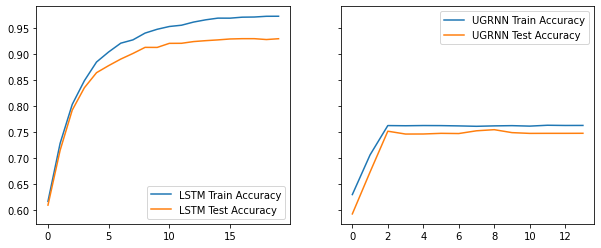

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model.history['eval_acc'])), ugrnn_model.history['eval_acc'],
         label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();

## Test network on new samples
---



In [40]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [41]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [42]:
sent_dict = {0: 'negative', 1: 'positive'}

In [43]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [44]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [45]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"

In [46]:
new_reviews = [review_score_10, review_score_4, review_score_1]
scores = [10, 4, 1]

In [47]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative
